In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
import json 
base_dir = 'results\\hold_out_set_and_predicted_faults\\'
import pickle
from sklearn.metrics import precision_recall_curve, auc,confusion_matrix
import json
import joblib

In [5]:
def load_data(file_name):
    df = pd.read_csv(base_dir+file_name)
    
    return df

from sklearn.metrics import silhouette_score

def train_and_fine_tune_kmeans(data, num_clusters, max_iterations=300, random_state=42):
    """
    Train and fine-tune a KMeans model with a specified number of clusters.

    Parameters:
    - data: array-like
        The training data for clustering.
    - num_clusters: int
        The number of clusters to create.
    - max_iterations: int, optional (default=300)
        Maximum number of iterations for the KMeans algorithm.
    - random_state: int, optional (default=42)
        Random seed for reproducibility.

    Returns:
    - trained_kmeans: KMeans
        The trained KMeans model.
    """

    # Initialize KMeans model with the specified number of clusters
    kmeans = KMeans(n_clusters=num_clusters, max_iter=max_iterations, random_state=random_state)

    # Fit the KMeans model to the training data
    kmeans.fit(data)

    # Fine-tune the model based on silhouette score
    silhouette_scores = []
    for n_clusters in range(2, num_clusters + 1):
        kmeans_temp = KMeans(n_clusters=n_clusters, max_iter=max_iterations, random_state=random_state)
        labels = kmeans_temp.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))

    # Choose the number of clusters with the highest silhouette score
    optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Add 2 because the loop starts from 2

    # Train the final KMeans model with the optimal number of clusters
    trained_kmeans = KMeans(n_clusters=optimal_num_clusters, max_iter=max_iterations, random_state=random_state)
    trained_kmeans.fit(data)

    print(f"Optimal Number of Clusters: {optimal_num_clusters}")

    return trained_kmeans

In [6]:
file_name = 'LOF_predicted_faults_vals_sampling_freq_5T.csv'
df_anomaly_data = load_data(file_name)

In [7]:
df_anomaly_data

,CHWC_VLV,CHWC_VLV_DM,MA_TEMP,OA_CFM,OA_DMPR,OA_DMPR_DM,OA_TEMP,RA_CFM,RA_DMPR,RA_DMPR_DM,...,SF_CS,SF_SPD,SF_SPD_DM,SF_WAT,SYS_CTL,ZONE_TEMP_1,ZONE_TEMP_2,ZONE_TEMP_3,ZONE_TEMP_4,ZONE_TEMP_5
0,-1.644869e-21,0.0,66.373856,357730.44,0.0,0.0,10.070026,8.529321e-01,1.0,1.0,...,0.0,0.9,0.0,-2.789806e-13,0.0,74.007662,66.765952,67.024479,66.761116,67.208673
1,-4.305709e-23,0.0,66.373856,357730.44,0.0,0.0,10.145008,8.522391e-01,1.0,1.0,...,0.0,0.9,0.0,-2.785283e-13,0.0,74.150663,66.761773,67.016600,66.759578,67.212355
2,1.508876e-22,0.0,66.373856,357730.44,0.0,0.0,10.220001,8.515480e-01,1.0,1.0,...,0.0,0.9,0.0,-2.780758e-13,0.0,74.278871,66.756084,67.006715,66.756457,67.213609
3,3.570875e-23,0.0,66.373800,357730.44,0.0,0.0,10.295026,8.508540e-01,1.0,1.0,...,0.0,0.9,0.0,-2.776254e-13,0.0,74.394392,66.749053,66.995111,66.751960,67.212685
4,8.407691e-23,0.0,66.373800,357730.44,0.0,0.0,10.370008,8.501664e-01,1.0,1.0,...,0.0,0.9,0.0,-2.771751e-13,0.0,74.499050,66.740836,66.981974,66.746226,67.209840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597644,2.874889e-25,0.0,56.157510,357730.44,0.0,0.0,46.238007,0.000000e+00,1.0,1.0,...,0.0,0.9,0.0,-2.538662e-24,0.0,73.540800,69.407456,69.102420,69.079044,68.594139
1597645,1.327021e-26,0.0,56.157510,357730.44,0.0,0.0,46.507996,-6.971870e-07,1.0,1.0,...,0.0,0.9,0.0,-6.716031e-25,0.0,73.628702,69.410776,69.107264,69.083009,68.618144
1597646,1.207096e-25,0.0,56.157510,357730.44,0.0,0.0,46.778008,6.971870e-07,1.0,1.0,...,0.0,0.9,0.0,-3.758598e-24,0.0,73.712645,69.414248,69.112331,69.087119,68.641854
1597647,-5.390609e-26,0.0,56.157510,357730.44,0.0,0.0,47.048029,2.323957e-07,1.0,1.0,...,0.0,0.9,0.0,-1.050154e-24,0.0,73.792124,69.417852,69.117605,69.091347,68.665255


In [8]:
df_anomaly_deduplicated = df_anomaly_data.drop_duplicates()

In [9]:
df_anomaly_deduplicated

,CHWC_VLV,CHWC_VLV_DM,MA_TEMP,OA_CFM,OA_DMPR,OA_DMPR_DM,OA_TEMP,RA_CFM,RA_DMPR,RA_DMPR_DM,...,SF_CS,SF_SPD,SF_SPD_DM,SF_WAT,SYS_CTL,ZONE_TEMP_1,ZONE_TEMP_2,ZONE_TEMP_3,ZONE_TEMP_4,ZONE_TEMP_5
0,-1.644869e-21,0.0,66.373856,357730.44,0.0,0.0,10.070026,8.529321e-01,1.0,1.0,...,0.0,0.9,0.0,-2.789806e-13,0.0,74.007662,66.765952,67.024479,66.761116,67.208673
1,-4.305709e-23,0.0,66.373856,357730.44,0.0,0.0,10.145008,8.522391e-01,1.0,1.0,...,0.0,0.9,0.0,-2.785283e-13,0.0,74.150663,66.761773,67.016600,66.759578,67.212355
2,1.508876e-22,0.0,66.373856,357730.44,0.0,0.0,10.220001,8.515480e-01,1.0,1.0,...,0.0,0.9,0.0,-2.780758e-13,0.0,74.278871,66.756084,67.006715,66.756457,67.213609
3,3.570875e-23,0.0,66.373800,357730.44,0.0,0.0,10.295026,8.508540e-01,1.0,1.0,...,0.0,0.9,0.0,-2.776254e-13,0.0,74.394392,66.749053,66.995111,66.751960,67.212685
4,8.407691e-23,0.0,66.373800,357730.44,0.0,0.0,10.370008,8.501664e-01,1.0,1.0,...,0.0,0.9,0.0,-2.771751e-13,0.0,74.499050,66.740836,66.981974,66.746226,67.209840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351497,2.874889e-25,0.0,56.157510,357730.44,0.0,0.0,46.238007,0.000000e+00,1.0,1.0,...,0.0,0.9,0.0,-2.538662e-24,0.0,73.540800,69.407456,69.102420,69.079044,68.594139
1351498,1.327021e-26,0.0,56.157510,357730.44,0.0,0.0,46.507996,-6.971870e-07,1.0,1.0,...,0.0,0.9,0.0,-6.716031e-25,0.0,73.628702,69.410776,69.107264,69.083009,68.618144
1351499,1.207096e-25,0.0,56.157510,357730.44,0.0,0.0,46.778008,6.971870e-07,1.0,1.0,...,0.0,0.9,0.0,-3.758598e-24,0.0,73.712645,69.414248,69.112331,69.087119,68.641854
1351500,-5.390609e-26,0.0,56.157510,357730.44,0.0,0.0,47.048029,2.323957e-07,1.0,1.0,...,0.0,0.9,0.0,-1.050154e-24,0.0,73.792124,69.417852,69.117605,69.091347,68.665255


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_elbow_silhouette(X, max_clusters=10, subsample_size=None):
    """
    Plots the elbow method and silhouette score for selecting the number of clusters for k-means clustering.

    Parameters:
    - X: Input data (numpy array or pandas DataFrame)
    - max_clusters: Maximum number of clusters to consider (default is 10)
    - subsample_size: Size of the subsample for silhouette score calculation (default is None, meaning no subsampling)
    """
    # Elbow Method
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    # Silhouette Score
    silhouette_scores = []
    if subsample_size is not None and subsample_size < len(X):
        indices = np.random.choice(len(X), size=subsample_size, replace=False)
        X_subsample = X[indices]
    else:
        X_subsample = X

    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        cluster_labels = kmeans.fit_predict(X_subsample)
        silhouette_scores.append(silhouette_score(X_subsample, cluster_labels))
    optimal_clusters = np.argmax(silhouette_scores) + 2
    print(f"The optimal number of based on Silhouette score clusters is: {optimal_clusters}")
    # Plot Elbow Method
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')

    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()


The optimal number of based on Silhouette score clusters is: 3


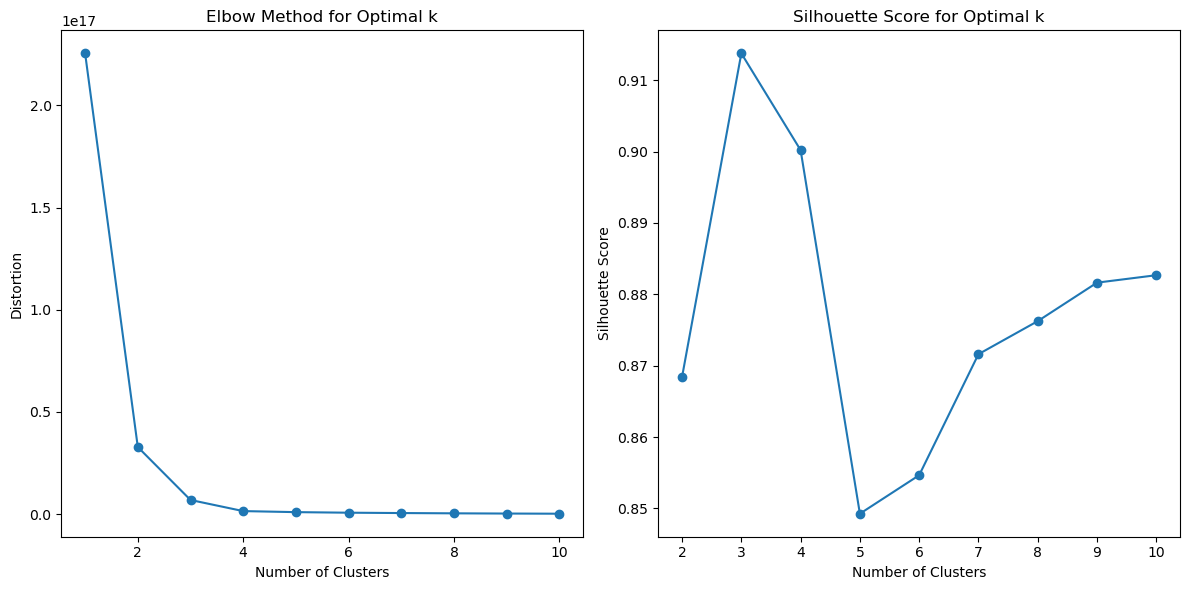

In [30]:
plot_elbow_silhouette(X = df_anomaly_deduplicated.values, subsample_size=1000) 

The optimal number of based on Silhouette score clusters is: 3


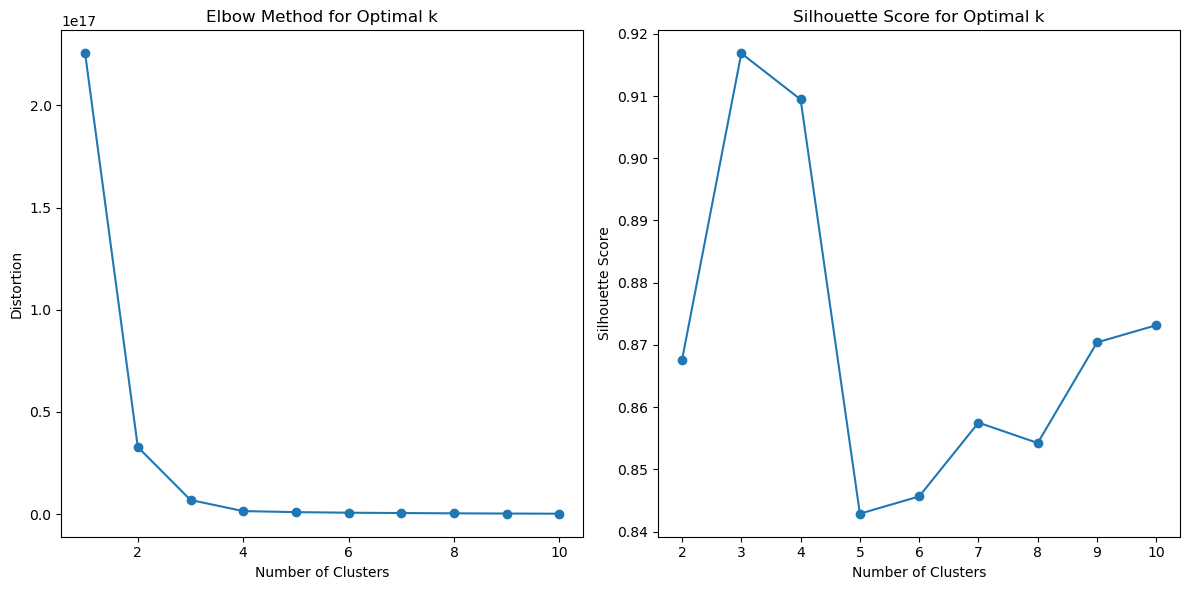

In [31]:
plot_elbow_silhouette(X = df_anomaly_deduplicated.values, subsample_size=10000) 

The optimal number of based on Silhouette score clusters is: 3


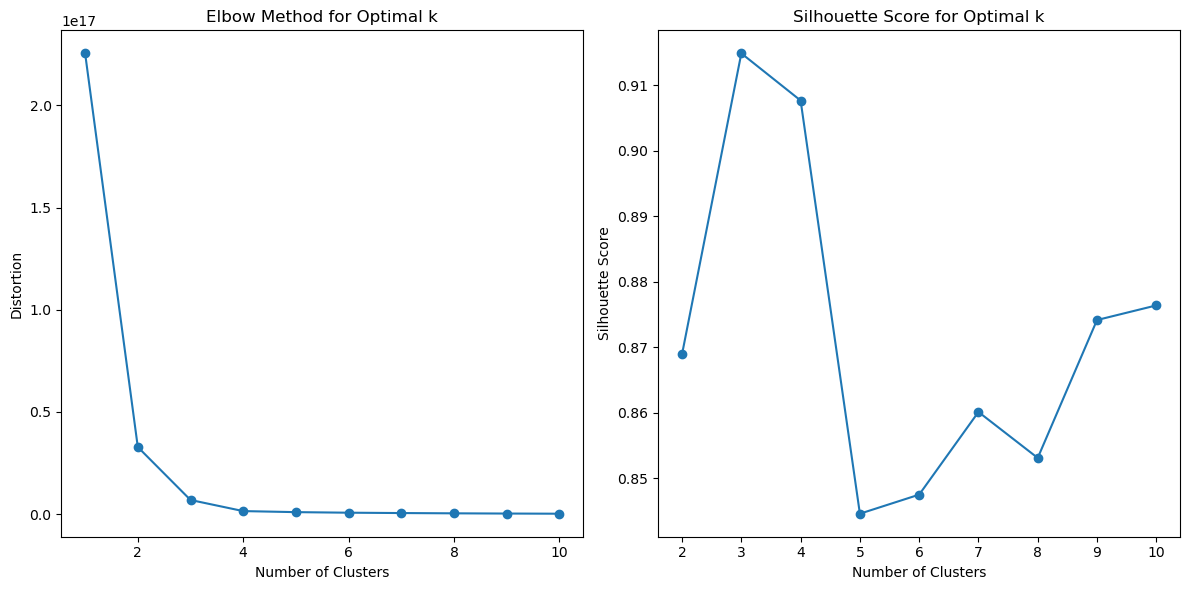

In [32]:
plot_elbow_silhouette(X = df_anomaly_deduplicated.values, subsample_size=100000) 

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # for 3D scatter plot

def visualize_clusters(X, cluster_labels, method='scatter', n_clusters=3):
    """
    Visualizes the distribution of clusters using different methods.

    Parameters:
    - X: Input data (numpy array or pandas DataFrame)
    - cluster_labels: Cluster labels assigned by KMeans
    - method: Method for visualization ('scatter', 'scatter_3d', 'centroids')
    - n_clusters: Number of clusters for KMeans (default is 3)
    """
    if method == 'scatter':
        # Scatter plot for 2D visualization
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', edgecolors='k', s=50)
        plt.title(f'KMeans Clustering (k={n_clusters}) - Cluster Distribution')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.colorbar(scatter, label='Cluster')
        plt.show()
    elif method == 'scatter_3d':
        # 3D Scatter plot for 3D visualization
        if X.shape[1] < 3:
            raise ValueError("Data should have at least 3 features for 3D scatter plot.")
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=cluster_labels, cmap='viridis', edgecolors='k', s=50)
        ax.set_title(f'KMeans Clustering (k={n_clusters}) - 3D Cluster Distribution')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Feature 3')
        fig.colorbar(scatter, label='Cluster')
        plt.show()
    else:
        raise ValueError("Invalid visualization method. Choose from 'scatter', 'scatter_3d', or 'centroids'.")

def train_and_visualize_kmeans(X, n_clusters=3, visualization_method='scatter'):
    """
    Trains the KMeans algorithm for the given number of clusters and visualizes the distribution of clusters.

    Parameters:
    - X: Input data (numpy array or pandas DataFrame)
    - n_clusters: Number of clusters for KMeans (default is 3)
    - visualization_method: Method for visualization ('scatter', 'scatter_3d', 'centroids')
    """
    # Train KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(3, X.shape[1]))
    reduced_data = pca.fit_transform(X)

    # Visualize clusters
    visualize_clusters(reduced_data, cluster_labels, method=visualization_method, n_clusters=n_clusters)

    return kmeans

def train_kmeans(data, n_clusters=3):
    """
    Trains a KMeans model with the provided number of clusters.

    Parameters:
    - data: Input data (numpy array or pandas DataFrame)
    - n_clusters: Number of clusters for KMeans (default is 3)

    Returns:
    - kmeans_model: Trained KMeans model
    - cluster_labels: Cluster labels assigned by KMeans
    """
    # Create and fit KMeans model
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans_model.fit_predict(data)

    return kmeans_model, cluster_labels





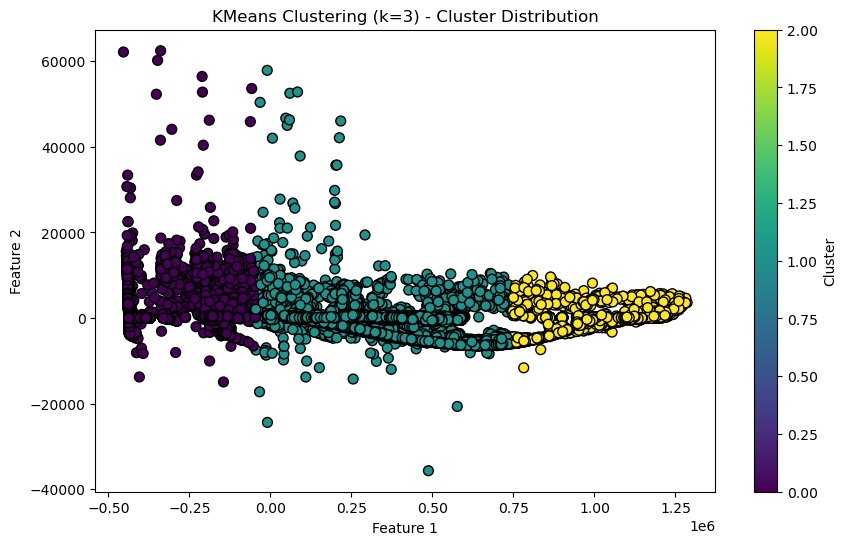

In [34]:
train_and_visualize_kmeans(df_anomaly_deduplicated.values, n_clusters=3, visualization_method='scatter') 

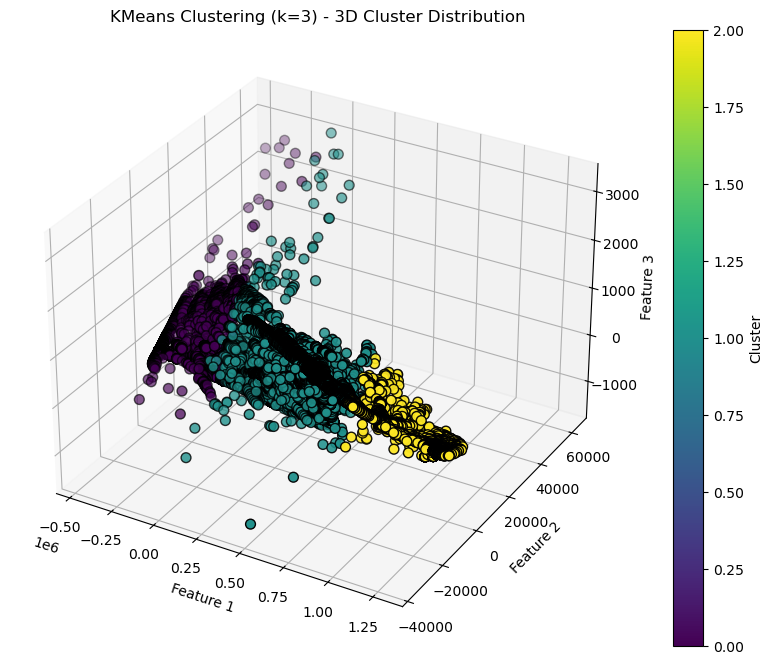

In [35]:
train_and_visualize_kmeans(df_anomaly_deduplicated.values, n_clusters=3, visualization_method='scatter_3d') 

In [44]:
kmean_model, cluster_labels = train_kmeans(df_anomaly_deduplicated.values)

In [95]:
joblib.dump(kmean_model, 'models/kmean_model.joblib')

['models/kmean_model.joblib']

In [96]:
np.save('models/cluster_labels.npy', cluster_labels)

In [236]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

def train_binary_classifier_for_clusters(cluster_labels, data, model_name='logistic_regression', test_size=0.2, random_state=42):
    """
    Trains a binary classifier for each cluster.

    Parameters:
    - cluster_labels: Cluster labels assigned by KMeans or any clustering algorithm
    - data: Input data (numpy array or pandas DataFrame)
    - model_name: Name of the binary classifier ('logistic_regression', 'random_forest', 'svm')
    - test_size: Proportion of the dataset to include in the test split (default is 0.2)
    - random_state: Seed for random number generation (default is 42)

    Returns:
    - classifiers: Dictionary containing trained classifiers for each cluster
    - accuracy_scores: Dictionary containing accuracy scores for each cluster
    """
    # Initialize dictionaries to store classifiers and accuracy scores
    classifiers = {}
    accuracy_scores = {}
    # Initialize dictionary to store results
    
    # Identify unique clusters
    unique_clusters = set(cluster_labels)
    results = {}
    for cluster in unique_clusters:
        print(f"Cluster Number: {cluster}")
        results[str(cluster)] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        #print(cluster)
        # Select data points for the current cluster
        cluster_indices = (cluster_labels == cluster)
        X_cluster, y_cluster = data[cluster_indices], np.zeros(sum(cluster_indices))  # Target label for the cluster is 0

        # Select an equal number of data points from other clusters
        other_clusters = list(set(unique_clusters) - {cluster})

        
        other_indices = []
        for other_cluster in other_clusters:
            other_cluster_indices = np.where(cluster_labels == other_cluster)[0]
            random_other_indices = np.random.choice(other_cluster_indices, int(sum(cluster_indices)/len(other_clusters)), replace=True)
            other_indices.extend(random_other_indices)

        X_other, y_other = data[other_indices], np.ones(sum(cluster_indices))  # Target label for other clusters is 1

        # Combine data for the current cluster and other clusters
        X_combined = np.vstack([X_cluster, X_other])
        y_combined = np.hstack([y_cluster, y_other])
        
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
        
        for train_index, test_index in skf.split(X_combined, y_combined):
            
            # Split data into training and testing sets for each fold
            X_train, X_test = X_combined[train_index], X_combined[test_index]
            y_train, y_test = y_combined[train_index], y_combined[test_index]
    
            # Initialize classifier
            if model_name == 'logistic_regression':
                classifier = LogisticRegression(random_state=random_state)
            elif model_name == 'random_forest':
                classifier = RandomForestClassifier(random_state=random_state)
            elif model_name == 'svm':
                classifier = SVC(random_state=random_state)
            else:
                raise ValueError("Invalid model_name. Choose from 'logistic_regression', 'random_forest', or 'svm'.")
    
            # Train the classifier
            classifier.fit(X_train, y_train)
    
            # Predict on the test set
            y_pred = classifier.predict(X_test)
    
            # Calculate and store metrics for each fold

            results[str(cluster)]['accuracy'].append(accuracy_score(y_test, y_pred))
            results[str(cluster)]['precision'].append(precision_score(y_test, y_pred))
            results[str(cluster)]['recall'].append(recall_score(y_test, y_pred))
            results[str(cluster)]['f1'].append(f1_score(y_test, y_pred))
    return results


In [237]:
results_logit_reg_cluster = train_binary_classifier_for_clusters(cluster_labels, df_anomaly_deduplicated.values, model_name='logistic_regression')



Cluster Number: 0
Cluster Number: 1
Cluster Number: 2


In [238]:
with open('results/logit_regression_cluster_models_10fold_results.json', "w") as outfile: 
        json.dump(results_logit_reg_cluster, outfile, indent=4)

In [ ]:
results_random_forest_cluster = train_binary_classifier_for_clusters(cluster_labels, df_anomaly_deduplicated.values, model_name='random_forest')



Cluster Number: 0


In [ ]:
results_svm_cluster = train_binary_classifier_for_clusters(cluster_labels, df_anomaly_deduplicated.values, model_name='svm')

